# Determination of ratio D in Variable Density Tesseroid Forward Calculation

## Hypotesis

We are going to start with certain assumptions. We will supose that the density is a linear function that dependends on a certain spherical coordinate. First, we will start with dependence only on height:

$\rho(\Delta h) = a\Delta h + b$

Lets compute the value of the gravity potential generated by a Tesseroid with such density by approximating it with a mesh of Tesseroids with constant densities. Each value will be the one that the density function assumes at the center of this little Tesseroids.

In order to do this we must know beforehand the shape of this mesh. Because the variation is only in the radius axis, the mesh can have no divisions in the lon lat axis, so only the radius axis will be divided. Although, a high value for the distance-size ratio D will be used, in order to increase precission in the calculation.

We can find out the optimal number of divisions in the radius axis ($n_r$) by calculating the potential generated by mesh with different values of $n_r$. For lower values of $n_r$, the potential values corresponding with $n_r$ and $n_r -1$ will be very different. But for higher $n_r$, the potential of the mesh will be closer to the true value.

In order to obtain this "true" value, we will calculate the potential for increasing values of $n_r$ until the difference between the potentials created with $n_r$ and $n_r - 1$ is smaller than $10^{-8}\%$.

**Import Packages**

In [1]:
from __future__ import division
import time
import numpy as np
from tesseroid_density import tesseroid
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt

%matplotlib inline

**Definition of linear density function**

In [2]:
def density_linear(lon, lat, height):
    return height/250. - 50

**Creation of the computation grid**

In [3]:
area = (-30, 30, -30, 30)
shape = (20, 20)
h = 10e3
lons, lats, heights = gridder.regular(area, shape, z=h)

**Bounds and D ratio of the Tesseroid Mesh**

In [4]:
D_high = 8
w, e, s, n, top, bottom = -10, 10, -10, 10, -3000, -50000

**Determination of optimal tesseroid mesh size**

In [5]:
"Single computation point"
lons_single = np.array([0.])
lats_single = np.array([0.])
heights_single = np.array([h])

"Initialization of the loop"
potential_single_point = []
nr_values = []
nr = 0
res = 1e42
while True:
    nr += 1
    mesh_shape = (nr, 1, 1)
    model_mesh = TesseroidMesh((w, e, s, n, top, bottom), mesh_shape)
    
    density_list = []
    for tess in model_mesh:
        lon1, lon2, lat1, lat2, r1, r2 = tess.get_bounds()
        density_list.append(density_linear(0.5*(lon1 + lon2),
                                           0.5*(lat1 + lat2), 0.5*(r1 + r2)))
    model_mesh.addprop("density", density_list)
    res_old = res
    res = getattr(tesseroid, 'potential')(lons_single,
                                          lats_single,
                                          heights_single,
                                          model_mesh,
                                          ratio=D_high)[0]
    potential_single_point.append(res)
    nr_values.append(nr)
    diff = 100*abs((res-res_old)/res_old)
    if diff < 1e-8:
        break

potential_single_point = np.array(potential_single_point)
nr_optimal = nr
print "Optimal nr: ", nr_optimal
mesh_shape = (nr_optimal, 1, 1)

Optimal nr:  449


**Plot**

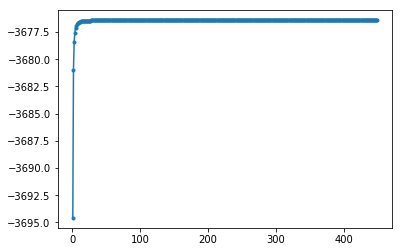

In [6]:
plt.plot(nr_values, potential_single_point, '-', marker='.')
plt.show()

## Calculation of "true" value

Let's calculate the "true" value of the potential for the optimal value of $n_r$ = 449

**Calculation of "true" potential values**

In [7]:
"We set the density of each tesseroid in the mesh as the"
"value of the linear density function in its center"
model_const = TesseroidMesh((w, e, s, n, top, bottom), mesh_shape)
density_list = []
for tess in model_const:
    lon1, lon2, lat1, lat2, r1, r2 = tess.get_bounds()
    density_list.append(density_linear(0.5*(lon1 + lon2),
                                       0.5*(lat1 + lat2),
                                       0.5*(r1 + r2)))
model_const.addprop("density", density_list)
true_potential = getattr(tesseroid, 'potential')(lons, lats, heights, model_const, ratio=D_high)

**Plot of the "true" potential values**

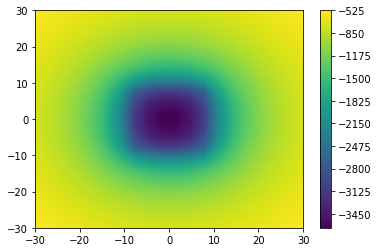

In [8]:
plt.contourf(lons.reshape(shape), lats.reshape(shape), true_potential.reshape(shape), 150)
plt.colorbar()
plt.show()

## Determination of distance-size ratio D for Tesseroid with variable density

Now we use the tesseroid with variable density to calculate the potential using several distance-size ratios and evaluate the maximum difference between them and the "true" potential. We will take the best value of D as the lower one that is below the $10^{-1}\%$ threshold.

In [9]:
# Calculate error for each distance-size ratio D
D_values = np.arange(0.5, 4.5, 0.5)
errors = []
model = Tesseroid(w, e, s, n, top, bottom, props={"density":density_linear})
for D in D_values:
    st = time.time()
    result = getattr(tesseroid, 'potential')(lons, lats, heights, [model], ratio=D)
    print D, "time: ", time.time() - st, "s"
    diff = 100*np.max(np.abs((result - true_potential)/true_potential))
    errors.append(diff)

0.5 time:  0.00903987884521 s
1.0 time:  0.0195159912109 s
1.5 time:  0.0506010055542 s
2.0 time:  0.0856599807739 s
2.5 time:  0.105750083923 s
3.0 time:  0.141519784927 s
3.5 time:  0.220919847488 s
4.0 time:  0.307276010513 s


**Plot D values vs Maximum difference**

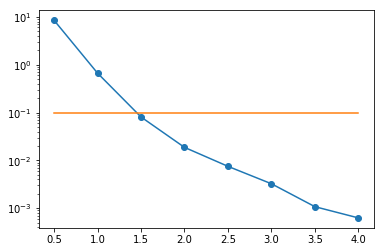

In [11]:
plt.plot(D_values, errors, 'o-')
plt.plot([D_values[0], D_values[-1]], [1e-1, 1e-1], '-')
plt.semilogy()
plt.show()